In [18]:
from tensorflow.keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()
(x_train, y_labels) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("./Data/train-morpho.csv")
test_morpho = pd.read_csv("./Data/t10k-morpho.csv")
train_morpho.drop(["index"], axis=1, inplace=True)
test_morpho.drop(["index"], axis=1, inplace=True)
train_morpho.slant = train_morpho.slant*180/np.pi #Lo pasamos a grados
test_morpho.slant = test_morpho.slant*180/np.pi

x_val = x_train[50000:]/255
y_val = train_morpho.slant.to_numpy()[50000:] 
x_train = x_train[:50000]/255
y_train = train_morpho.slant.to_numpy()[:50000]
labels = np.unique(y_labels)

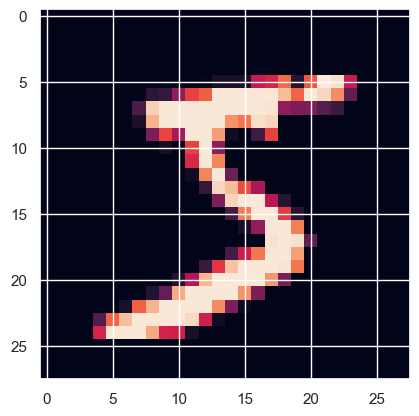

In [19]:
plt.imshow(x_train[0])

Text(0.5, 1.0, 'Data Distribution')

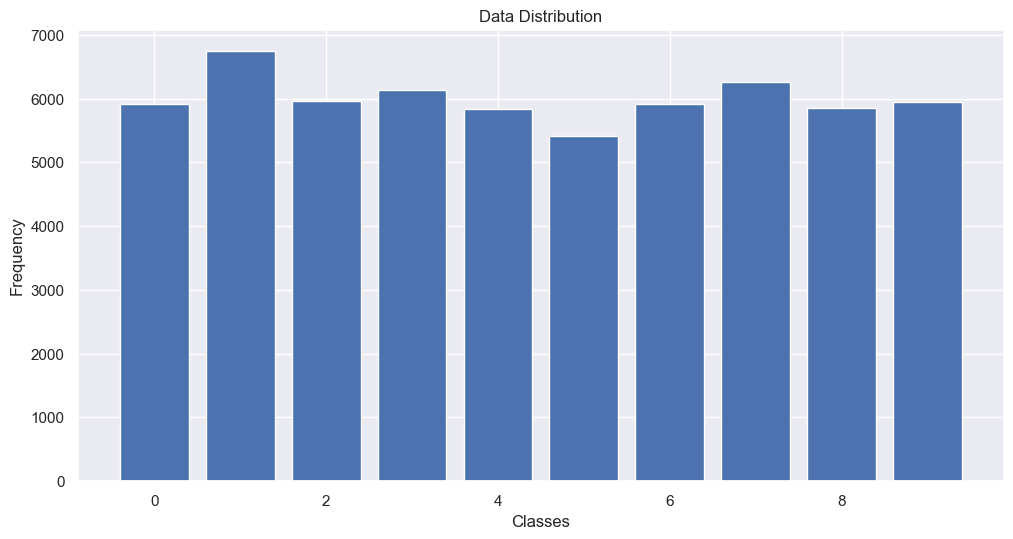

In [64]:
num, frequency = np.unique(y_labels, return_counts=True)
plt.bar(labels, frequency)
plt.gcf().tight_layout(pad=0)
plt.gcf().set_figwidth(10)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Data Distribution")

<Axes: >

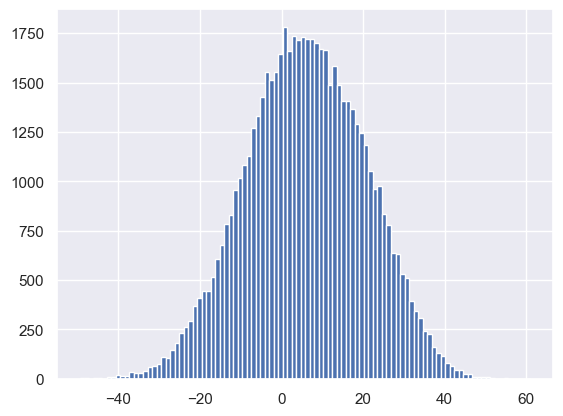

In [11]:
train_morpho.slant.hist(bins=100)

In [12]:
train_morpho.iloc[y_labels==1]

,area,length,thickness,slant,width,height
3,67.3125,22.849242,2.919769,29.174163,5.358179,19.724599
6,69.3750,19.838835,3.457017,-8.889683,5.026869,19.711565
8,41.8125,20.363961,2.190367,-4.378080,3.772309,19.458175
14,44.1250,21.692388,2.216605,-3.072578,3.974149,19.538955
23,64.6875,22.245689,2.854460,30.190546,5.230590,19.475603
...,...,...,...,...,...,...
59958,47.7500,22.977922,2.160946,23.981700,4.160436,19.564109
59965,63.9375,24.341883,2.577189,37.785202,5.596039,19.560789
59979,48.6250,23.952796,2.155981,28.702996,4.343587,19.500440
59984,59.5625,25.609650,2.378904,37.924730,5.011157,19.546802


# Slant vs Morphos

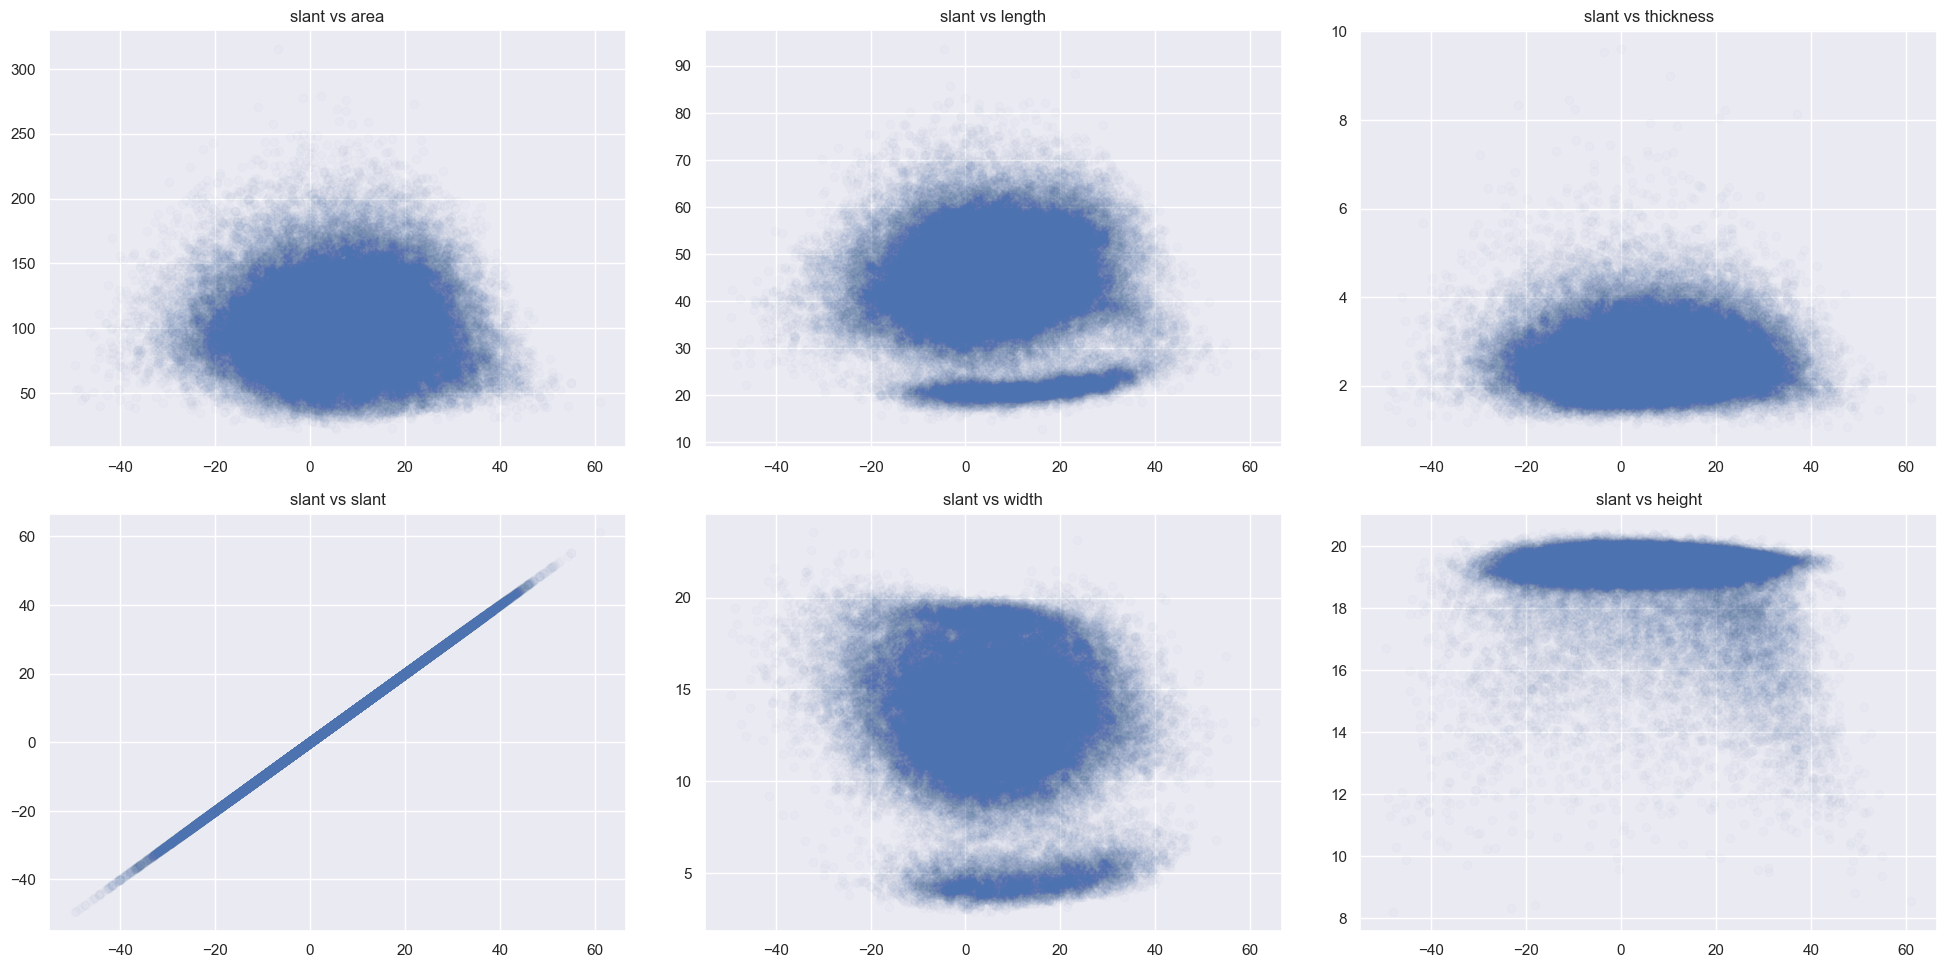

In [20]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
fig.tight_layout(pad=2)

for i in range(2):
    for j in range(3):
        morph = train_morpho.columns[3*i+j]
        axs[i][j].set_title(f"slant vs {morph}")
        axs[i][j].scatter(train_morpho.slant, train_morpho[morph], alpha=0.02)

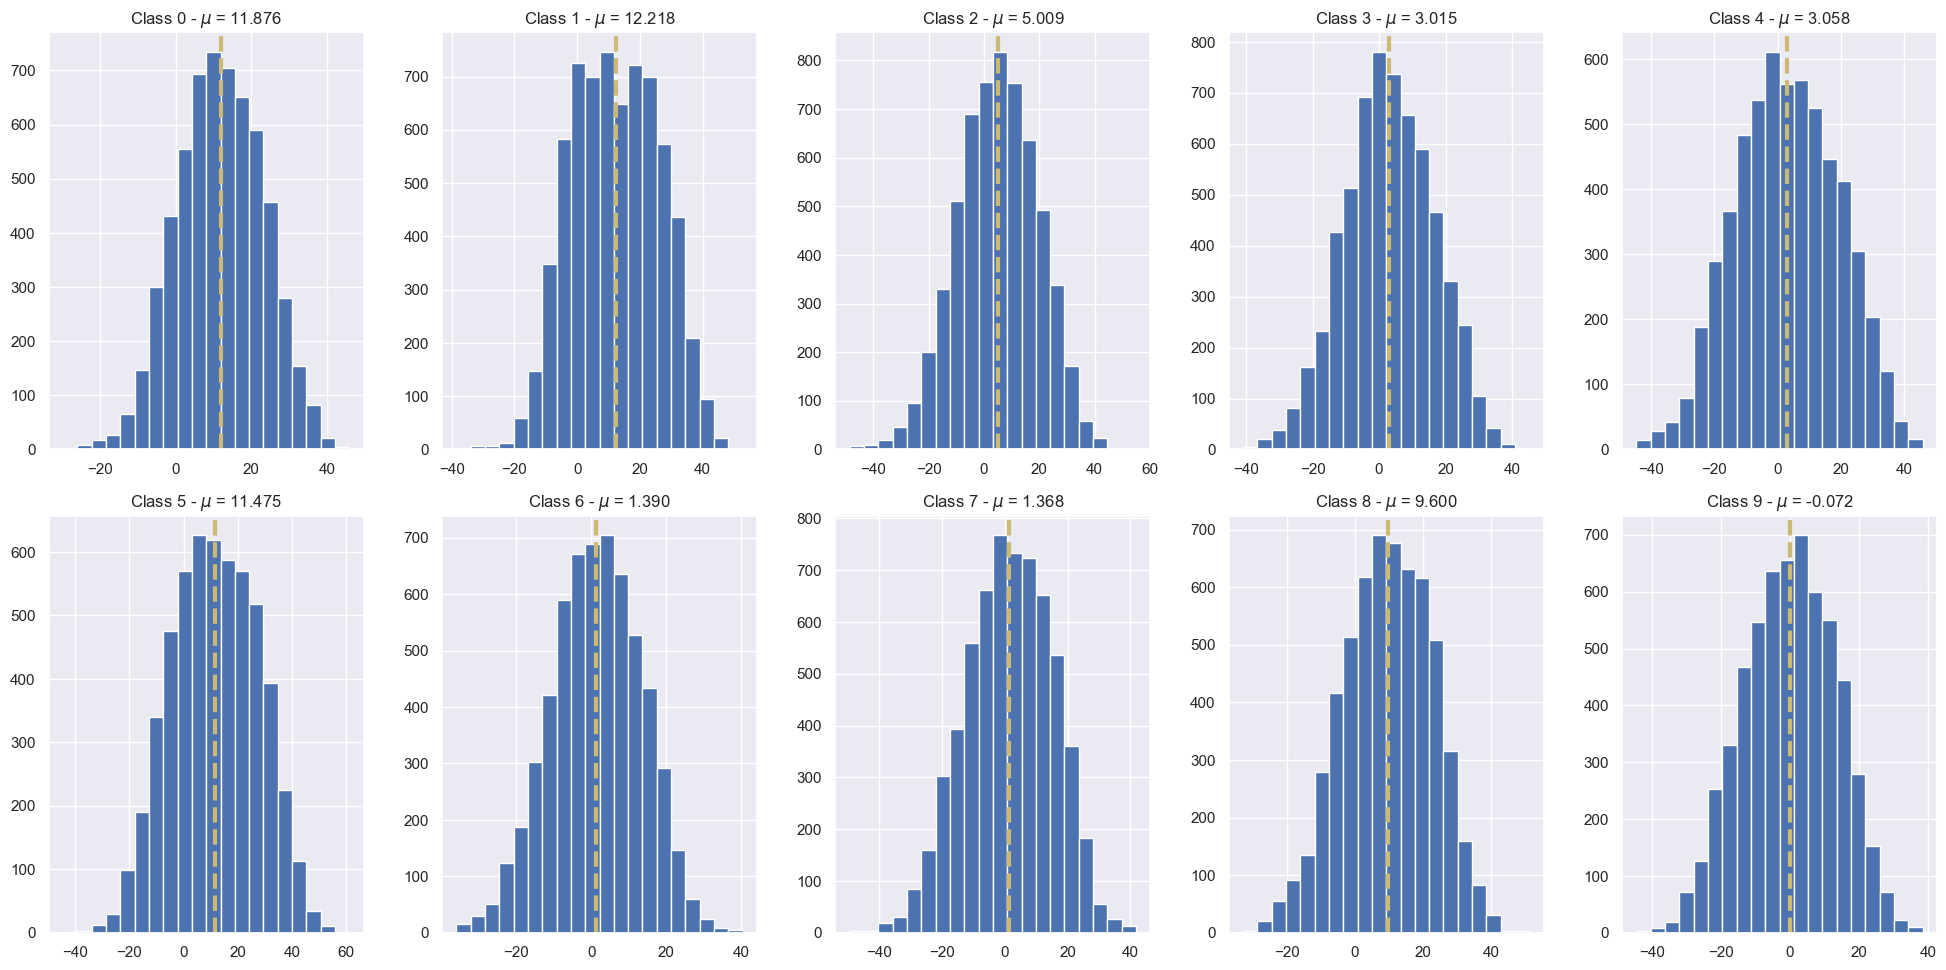

In [21]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
fig.tight_layout(pad=2)

for i in range(2):
    for j in range(5):
        mu = train_morpho.iloc[y_labels==i*5+j].slant.mean()
        axs[i][j].set_title(f"Class {i*5+j} - $\mu$ = {mu:.3f}")
        axs[i][j].hist(train_morpho.iloc[y_labels==i*5+j].slant, bins=20)
        axs[i][j].axvline(mu, color='y', linestyle='dashed', linewidth=3)

In [39]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow_addons as tfa
import tensorflow as tf
import importlib as imp
import helper
imp.reload(helper)

<module 'helper' from 'c:\\Users\\Gonzalo\\Documents\\PythonWorkspace\\TP1_RN\\TP1_RN\\MorphometricMNIST\\helper.py'>

In [52]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001

## Predict using image only

In [53]:
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNISTBase/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 100)               78500     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 88,701
Trainable params: 88,701
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=x_train, y =y_train, validation_data=(x_val, y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)

Epoch 1/200
782/782 [==============================] - 3s 3ms/step - loss: 8.3945 - mae: 8.3945 - val_loss: 2.7733 - val_mae: 2.7733 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 1.3686 - mae: 1.3686 - val_loss: 0.6401 - val_mae: 0.6401 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 3ms/step - loss: 0.4298 - mae: 0.4298 - val_loss: 0.3894 - val_mae: 0.3894 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2986 - mae: 0.2986 - val_loss: 0.2509 - val_mae: 0.2509 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2735 - mae: 0.2735 - val_loss: 0.2495 - val_mae: 0.2495 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2570 - mae: 0.2570 - val_loss: 0.3358 - val_mae: 0.3358 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2258 - mae: 0.2258 - va

In [56]:
model.save("./Model/MorphometricMNISTBase")

INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTBase\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTBase\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


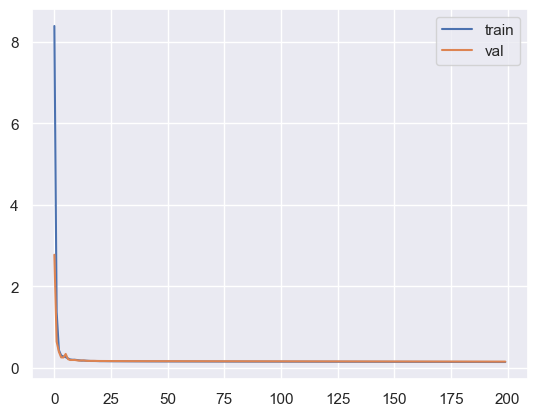

In [59]:
mode = load_model("./Model/MorphometricMNISTBase", compile=False)
histo = pd.read_csv("./Model/MorphometricMNISTBase/training_history.log")
plt.plot(histo["mae"], label="train")
plt.plot(histo["val_mae"], label="val")
plt.legend()
plt.show()

In [60]:
model = load_model("./Model/MorphometricMNISTBase", compile=False)
predicted = model.predict(x_test).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 1s 1ms/step


,pred,target
0,4.180349,4.066199
1,-11.081480,-9.962917
2,17.252556,16.638250
3,4.094615,4.146705
4,-8.293284,-7.378214
...,...,...
9995,-0.977837,-1.446727
9996,-3.583157,-4.309251
9997,11.325055,11.246739
9998,30.283638,30.389567


## Predict using image and label

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNISTBase/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
model.summary()